# Final Project on Supervised Learning

### LAN and WAN Response Analysis 
- Description: The source of our data comes from the variablity of a LAN network when it is connecting to the Internet. The data is collected by the ping response time from the devices of the local internet router and to the first-hop server on the internet.
- Group Members: Eric Topmiller, Viphu Nguyen, David Gigremosa, Paul Rozario

Question to Answer: What is the worst time of day for ping response with ethernet and wireless for both LAN and WAN?

In [2]:

# Import libraries
import sys
sys.path.append('C:\\Users\\mgwyn_dgsghje\\AppData\\Roaming\\Python\\Python38\\Scripts')
!pip install numpy --user --upgrade --ignore-installed
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style

  Using cached numpy-1.22.3-cp38-cp38-win_amd64.whl (14.7 MB)


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\mgwyn_dgsghje\\AppData\\Roaming\\Python\\Python38\\site-packages\\numpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Check the permissions.



In [3]:
# Set the dataset from the network csv
df = pd.read_csv('ping_data_rp829c7e0e_eth.csv')
df.head()
df.sort_values('timestamp', inplace=True)

### Data Wrangling and Filtering the Data
- Done by Viphu Nguyen and Eric Topmiller

In [4]:
# Finding the missing values from the ping dataset
df.isna().sum()

timestamp      0
location       0
source         0
local_dest     0
local_avg      0
remote_dest    0
remote_avg     0
dtype: int64

In [5]:
# Duplicate the dataframe in case of crashes
df1 = df.copy()

In [6]:
# Removing unncessary columns from the ping dataset
df1 = df1.drop(['location', 'local_dest', 'remote_dest'], axis = 1)
df1

,timestamp,source,local_avg,remote_avg
0,1.559041e+09,ethernet,0.19,8.14
1,1.559041e+09,ethernet,0.15,7.75
2,1.559041e+09,ethernet,0.15,8.68
3,1.559041e+09,ethernet,0.15,8.08
4,1.559041e+09,ethernet,0.15,8.20
...,...,...,...,...
69740,1.559691e+09,ethernet,0.15,8.70
69741,1.559691e+09,ethernet,0.15,8.43
69742,1.559691e+09,ethernet,0.15,8.71
69743,1.559691e+09,ethernet,0.15,8.42


#### *Each header definition*
- Timestamp: The current time of an event that is recorded
- Source: Network Source
- Local_avg: Response Time for local network (ms)
- Remote_avg: Response time for remote network (ms)

In [7]:
# create a column that is the start of the range of hours of the day, show the head, show it has all 24 hours of the day
#df1['hour'] = (df['timestamp'].astype(int) % 86400) / 14400
df1['hour'] = (df['timestamp'].astype(int) % 86400) / 28800
df1['hour'] = df1['hour'].astype(int)
print(df1.head())
print(df1['hour'].unique())
print(df1.info())

      timestamp    source  local_avg  remote_avg  hour
0  1.559041e+09  ethernet       0.19        8.14     1
1  1.559041e+09  ethernet       0.15        7.75     1
2  1.559041e+09  ethernet       0.15        8.68     1
3  1.559041e+09  ethernet       0.15        8.08     1
4  1.559041e+09  ethernet       0.15        8.20     1
[1 2 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69745 entries, 0 to 69744
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   69745 non-null  float64
 1   source      69745 non-null  object 
 2   local_avg   69745 non-null  float64
 3   remote_avg  69745 non-null  float64
 4   hour        69745 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 2.9+ MB
None


count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64
count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64


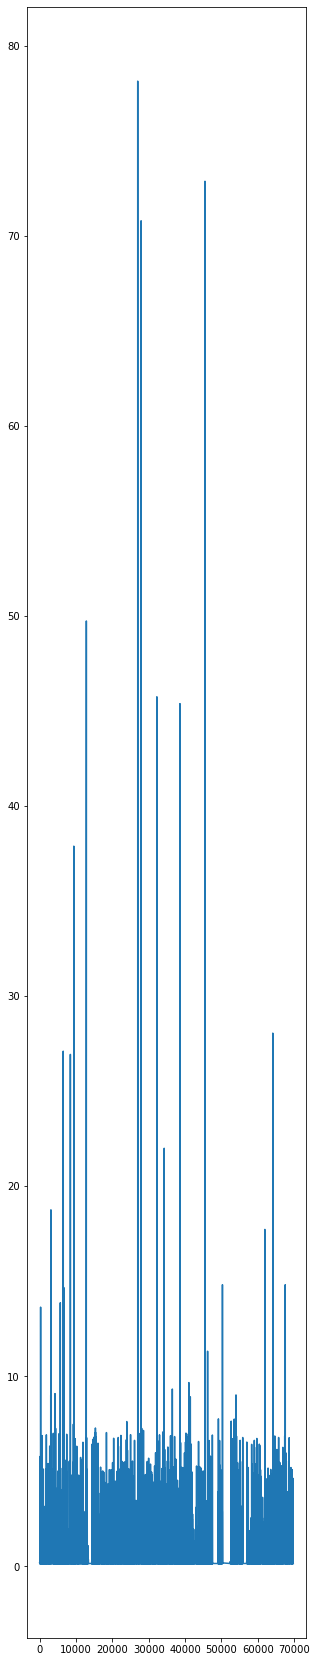

In [8]:
# remove the rows with avg of 9999.9999 since they are failures and will skew the data
#df1 = df1[(df1['local_avg'] != 9999) & (df1['remote_avg'] < 1000.0)]
df1 = df1.reset_index()
print(df1['local_avg'].describe())
print(df1['remote_avg'].describe())
# for plotting throw out the large values so we can better see the more common local_avg
df_small_local = df1[(df1['local_avg'] < 500)]
df_small_local['local_avg'].plot(figsize=(5,30))
plt.show()

In [9]:
# find the quartiles of the time data so we can create local average categorical variable
print(df1['local_avg'].describe())

count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64


In [10]:
# create the categorical variable local_delay for the local delay of low, average, high using the quartiles
# we will leave in the 9999.9999 since they probably represent failures and should be placed the high
bins = [float('-inf'), 0.149, 0.15, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['local_delay'] = pd.cut(df1['local_avg'], bins=bins, labels=labels)
df1.head()
print(df1['local_delay'].unique())


['Large', 'Medium', 'Small']
Categories (3, object): ['Small' < 'Medium' < 'Large']


In [11]:
# do a categorical variable for ismean for the local_avg because we have a lot
# of them
df1['ismean'] = 0
df1.loc[df1["local_avg"] == 0.15, "ismean"] = 1

In [12]:
# do some range categorical variables to section off the dataset based on the plot of local_avg below 500
df1['gr500'] = 0
df1.loc[df1['local_avg'] > 500.0, 'gr500'] = 1
df1['gr55'] = 0
df1.loc[(df1['local_avg'] > 55.0) & (df1['local_avg'] <= 500.0), 'gr55'] = 1
df1['gr40'] = 0
df1.loc[(df1['local_avg'] > 40.0) & (df1['local_avg'] <= 55.0), 'gr40'] = 1
df1['gr30'] = 0
df1.loc[(df1['local_avg'] > 30.0) & (df1['local_avg'] <= 40.0), 'gr30'] = 1
df1['gr20'] = 0
df1.loc[(df1['local_avg'] > 20.0) & (df1['local_avg'] <= 30.0), 'gr20'] = 1
df1['gr10'] = 0
df1.loc[(df1['local_avg'] > 10.0) & (df1['local_avg'] <= 20.0), 'gr10'] = 1
df1['gr0'] = 0
df1.loc[df1['local_avg'] <= 10.0, 'gr0'] = 1

### Data Visualizations 
- Done by Viphu Nguyen

count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64

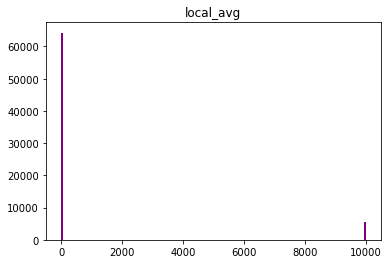

In [13]:
# Histogram for 'local_avg' response time (local) column
df1.hist(column='local_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['local_avg'].describe()

count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64

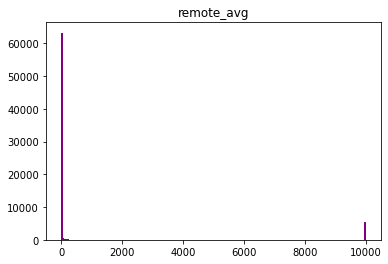

In [14]:
# Histogram for 'remote_avg' response time (local) column
df1.hist(column='remote_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['remote_avg'].describe()

Analysis: The histogram tells us that the the response time (ms) is estimated largely between 0 to 2,000 while there is a fewer amount at closer to 10,000 frequency for the response time between 8,000 to 10,000

In [15]:
# Duplicate the dataframe in case of crashes
df2 = df1.copy()

In [16]:
# map the local_delay and remote_delay to integers since that is what is needed by the classifier
df2['local_delay_int'] = df2['local_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
#df2['remote_delay_int'] = df2['remote_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
print(df2['local_delay_int'].unique())
#print(df2['remote_delay_int'].unique())
X = df2.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'local_delay', 'hour'], axis = 1)
y = df2['hour']
print(X.head())
print(y.head())

[2 1 0]
   ismean  gr500  gr55  gr40  gr30  gr20  gr10  gr0  local_delay_int
0       0      0     0     0     0     0     0    1                2
1       1      0     0     0     0     0     0    1                1
2       1      0     0     0     0     0     0    1                1
3       1      0     0     0     0     0     0    1                1
4       1      0     0     0     0     0     0    1                1
0    1
1    1
2    1
3    1
4    1
Name: hour, dtype: int32


In [17]:
# split out the test and train datasets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=99)
print(X_train, y_train)

       ismean  gr500  gr55  gr40  gr30  gr20  gr10  gr0  local_delay_int
33973       1      0     0     0     0     0     0    1                1
68346       1      0     0     0     0     0     0    1                1
18644       1      0     0     0     0     0     0    1                1
11347       1      0     0     0     0     0     0    1                1
59206       1      0     0     0     0     0     0    1                1
...       ...    ...   ...   ...   ...   ...   ...  ...              ...
57042       1      0     0     0     0     0     0    1                1
36008       1      0     0     0     0     0     0    1                1
46265       0      0     0     0     0     0     0    1                2
23587       1      0     0     0     0     0     0    1                1
29313       0      0     0     0     0     0     0    1                2

[55796 rows x 9 columns] 33973    0
68346    2
18644    1
11347    2
59206    2
        ..
57042    1
36008    1
46265    2

### Use scikit-learn for Logistic Regression and DecisionTree Classification, XGBoost, Keras, Pytorch to train, test and predict a categorical variable. Use appropriate metric and interpret themeaning of the score

### Logistic Regression

In [18]:
LogReg = LogisticRegression()

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_test)

In [19]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1 2]
Intercept [-0.02235625 -0.02000223  0.04235849]
Coefficients [[-0.02669646  0.09006309 -0.0338244   0.0136457  -0.01528755  0.01955446
   0.00705299 -0.09012795 -0.03178324]
 [-0.01305177 -0.06378792  0.01748828 -0.03445265  0.02880389  0.01795731
  -0.00651506  0.06357021 -0.01419089]
 [ 0.03974822 -0.02627518  0.01633613  0.02080694 -0.01351633 -0.03751178
  -0.00053793  0.02655774  0.04597412]]


In [20]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.3669080220804359
              precision    recall  f1-score   support

           0       0.54      0.13      0.21      4610
           1       0.24      0.00      0.01      4525
           2       0.35      0.93      0.51      4814

    accuracy                           0.37     13949
   macro avg       0.38      0.36      0.24     13949
weighted avg       0.38      0.37      0.25     13949



### Decision Tree
- Done by Viphu Nguyen and Eric Topmiller

In [21]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=99)

In [22]:
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.3669080220804359

##### Plot a Decision Tree

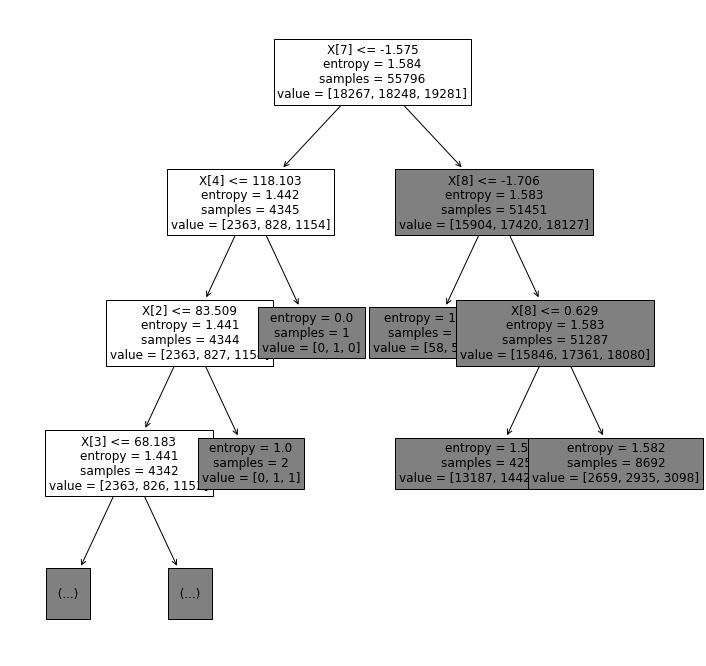

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 3,fontsize=12);

###  Show feature importance in XGBoost by using xgb.plot.importance

In [24]:
!pip install xgboost
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, n_estimators=100, seed=99) 
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.366908


## Keras
### model from https://www.kaggle.com/code/nitinsss/time-series-prediction-with-keras-for-beginners/notebook

In [25]:
# uninstall existing tensorflow-macos and tensorflow-metal
!pip uninstall tensorflow-macos
!pip uninstall tensorflow-metal
!pip install tensorflow-macos
!pip install tensorflow-metal
# Upgrade tensorflow-deps
!pip install tensorflow-deps --force-reinstall
# or point to specific conda environment
#conda install -c apple tensorflow-deps --force-reinstall -n my_env 
!pip install tensorflow

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
ERROR: Could not find a version that satisfies the requirement tensorflow-deps (from versions: none)
ERROR: No matching distribution found for tensorflow-deps


In [26]:
# create the model input layers
input_layer = Input(shape=(9), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [27]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 60)                600       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Make the dataframe like the kaggle example
df3 = df2.copy()
df3.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'local_delay'], axis = 1, inplace=True)
df3.head()
df_new = df3.copy()

In [29]:
# create the training, validation, and test inputs
df_copy = df3.copy()
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (62944, 9) (62944,)
Shape of validation inputs, validation target: (3313, 9) (3313,)
Shape of test inputs, test target: (3488, 9) (3488,)


In [30]:
# We will normalize our data in the range in the range (0.01, 0.99) before feeding it to the the neural network.
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [31]:
# training and validation
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/30
12589/12589 [==============================] - 16s 1ms/step - loss: 0.1674 - val_loss: 0.2441
Epoch 2/30
12589/12589 [==============================] - 12s 972us/step - loss: 0.1635 - val_loss: 0.2347
Epoch 3/30
12589/12589 [==============================] - 12s 947us/step - loss: 0.1630 - val_loss: 0.2411
Epoch 4/30
12589/12589 [==============================] - 12s 941us/step - loss: 0.1630 - val_loss: 0.2414
Epoch 5/30
12589/12589 [==============================] - 12s 936us/step - loss: 0.1630 - val_loss: 0.2364
Epoch 6/30
12589/12589 [==============================] - 12s 985us/step - loss: 0.1629 - val_loss: 0.2351
Epoch 7/30
12589/12589 [==============================] - 13s 997us/step - loss: 0.1629 - val_loss: 0.2386
Epoch 8/30
12589/12589 [==============================] - 12s 952us/step - loss: 0.1629 - val_loss: 0.2302
Epoch 9/30
12589/12589 [==============================] - 12s 916us/step - loss: 0.1629 - val_loss: 0.2363
Epoch 10/30
12589/12589 [==============

In [32]:
# do the prediction
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [33]:
# find the R2 score
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: -0.382


In [34]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual 8 hour period'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted 8 hour period'])

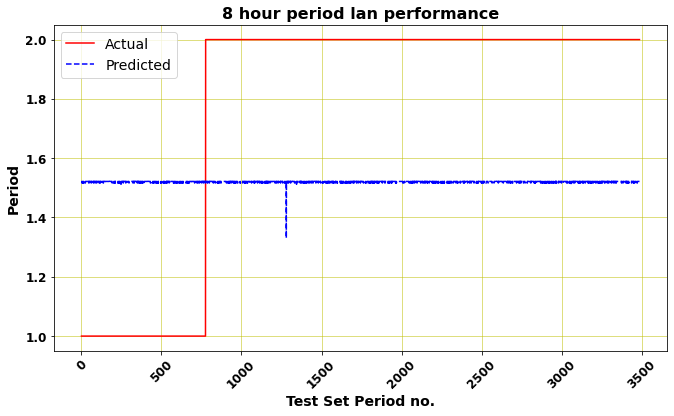

In [35]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('8 hour period lan performance', weight='bold', fontsize=16)
plt.ylabel('Period', weight='bold', fontsize=14)
plt.xlabel('Test Set Period no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Compare the results of the algorithms (comparison, conclusion, challenges...etc.)

### Outcome of our analysis